<a href="https://colab.research.google.com/github/Br-alexis73/Face_recognition/blob/master/fr_experiment_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'lfw-dataset:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F26922%2F34595%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240419%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240419T152011Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3Db4ec61946419ca8b830a0f4613cac81dffb050d7d712972d73e73a8d24cc40a231fb1a47a2c7bce99a68ff93e9ac40d5a337ede5b14e8940c63ba216337c90b4cc432075b2f24e158971a25f9ecb52e84512e1cdc8473afcdfc20275099542b8cc23208d379bed1a7e644e96a929b7dbb91a7019f5331c94ea9f46d05bdd60badb9169961ed1faa90ae1290e3919c42a5736aa4fd68b941df0dac0e6957e4528a6663da154303292f0925fe7bc92d10ad202845647f7a1eff66f586604bb52c0626b2d95f3daf452d5dae6be3e0f2daf1e3177513be89acda9a7114a083009f77cf36a5edd56f41bb1bf1ba424974542d3b8bd7ac3ec5ab7122a096e033e4df9'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 117895655 bytes downloaded
Downloaded and uncompressed: lfw-dataset
Data source import complete.


In [2]:
import os
import pandas as pd

dataset_path = '../input/lfw-dataset/lfw-deepfunneled/lfw-deepfunneled'

# Generate a list of (name, image count) tuples
names_images = []

for name in os.listdir(dataset_path):
    directory = os.path.join(dataset_path, name)
    if os.path.isdir(directory):
        image_count = len([i for i in os.listdir(directory) if i.endswith('.jpg')])
        if image_count >= 20:  # Check if the count is 10 or more
            names_images.append((name, image_count))

# Count the number of people with 10 or more images
number_of_people = len(names_images)
print(f"Number of people with 20 or more images: {number_of_people}")

# Create a DataFrame
lfw_allnames = pd.DataFrame(names_images, columns=['name', 'images'])

# Save the DataFrame to a CSV file
lfw_csv_path = '../input/lfw-dataset/lfw_allnames.csv'
lfw_allnames.to_csv(lfw_csv_path, index=False)

print(f"CSV file created at: {lfw_csv_path}")

Number of people with 20 or more images: 62
CSV file created at: ../input/lfw-dataset/lfw_allnames.csv


In [3]:
import os
import shutil
import pandas as pd

# Define the path to the dataset and the new directory
dataset_path = '../input/lfw-dataset/lfw-deepfunneled/lfw-deepfunneled'
new_dir_path = '../lfw-data-experiment'
csv_path = '../input/lfw-dataset/lfw_allnames.csv'

# Read the CSV file to get the list of names
all_names_df = pd.read_csv(csv_path)
names_list = all_names_df['name'].tolist()

# Create the new directory if it doesn't exist
if not os.path.exists(new_dir_path):
    os.makedirs(new_dir_path)

# Move the folders
for name in names_list:
    source_folder = os.path.join(dataset_path, name)
    destination_folder = os.path.join(new_dir_path, name)

    # Check if the destination folder already exists
    if os.path.exists(destination_folder):
        # Remove the existing folder
        shutil.rmtree(destination_folder)

    # Check if the source folder exists before moving
    if os.path.exists(source_folder):
        shutil.move(source_folder, destination_folder)
    else:
        print(f"Folder for {name} does not exist in the dataset path.")

print("Folders moved successfully.")


Folders moved successfully.


In [4]:
import os

# Correct path according to your folder structure
lfw_data_experiment = '../lfw-data-experiment'

people_data = os.listdir(lfw_data_experiment)
print(len(people_data))

people = []
for item in people_data:
    all_names = os.listdir(lfw_data_experiment + '/' + item)
    for person in all_names:
        people.append((item, lfw_data_experiment + '/' + item + '/' + person))

print(people)


62
[('Roh_Moo-hyun', '../lfw-data-experiment/Roh_Moo-hyun/Roh_Moo-hyun_0015.jpg'), ('Roh_Moo-hyun', '../lfw-data-experiment/Roh_Moo-hyun/Roh_Moo-hyun_0029.jpg'), ('Roh_Moo-hyun', '../lfw-data-experiment/Roh_Moo-hyun/Roh_Moo-hyun_0016.jpg'), ('Roh_Moo-hyun', '../lfw-data-experiment/Roh_Moo-hyun/Roh_Moo-hyun_0007.jpg'), ('Roh_Moo-hyun', '../lfw-data-experiment/Roh_Moo-hyun/Roh_Moo-hyun_0012.jpg'), ('Roh_Moo-hyun', '../lfw-data-experiment/Roh_Moo-hyun/Roh_Moo-hyun_0008.jpg'), ('Roh_Moo-hyun', '../lfw-data-experiment/Roh_Moo-hyun/Roh_Moo-hyun_0030.jpg'), ('Roh_Moo-hyun', '../lfw-data-experiment/Roh_Moo-hyun/Roh_Moo-hyun_0004.jpg'), ('Roh_Moo-hyun', '../lfw-data-experiment/Roh_Moo-hyun/Roh_Moo-hyun_0020.jpg'), ('Roh_Moo-hyun', '../lfw-data-experiment/Roh_Moo-hyun/Roh_Moo-hyun_0006.jpg'), ('Roh_Moo-hyun', '../lfw-data-experiment/Roh_Moo-hyun/Roh_Moo-hyun_0026.jpg'), ('Roh_Moo-hyun', '../lfw-data-experiment/Roh_Moo-hyun/Roh_Moo-hyun_0022.jpg'), ('Roh_Moo-hyun', '../lfw-data-experiment/Roh_Moo

In [5]:
import pandas as pd

# Create a DataFrame from the list of tuples
people_df = pd.DataFrame(people, columns=['person', 'path'])

# Count the number of samples for each person
person_count = people_df['person'].value_counts()

print("Total number of images of people in the dataset: ", len(people_df))
print("Samples in each category: ")
print(person_count)


Total number of images of people in the dataset:  3023
Samples in each category: 
person
George_W_Bush        530
Colin_Powell         236
Tony_Blair           144
Donald_Rumsfeld      121
Gerhard_Schroeder    109
                    ... 
Michael_Bloomberg     20
Jiang_Zemin           20
Igor_Ivanov           20
Angelina_Jolie        20
Paul_Bremer           20
Name: count, Length: 62, dtype: int64


In [6]:
import cv2
import os

# Specify the base path to the dataset containing subdirectories for each person
path = '../lfw-data-experiment'

# Specify the desired size for the images
im_size = 250

# Initialize lists to store the images and labels
images = []
labels = []

# List all the people's subdirectories in the base dataset folder
people_data = os.listdir(path)

# Loop through each subdirectory corresponding to a person
for person_name in people_data:
    # Construct the path to the person's subdirectory
    person_path = os.path.join(path, person_name)

    # List all image filenames in the person's subdirectory
    filenames = [f for f in os.listdir(person_path) if f.endswith(('.jpg'))]

    # Loop through each image filename
    for f in filenames:
        # Construct the full path to the image
        file_path = os.path.join(person_path, f)

        # Read the image from the file
        img = cv2.imread(file_path)

        # Resize the image
        img = cv2.resize(img, (im_size, im_size))

        # Append the image to the images list
        images.append(img)

        # Append the label (person's name) to the labels list
        labels.append(person_name)


In [7]:
import numpy as np

images = np.array(images)

images = images.astype('float32') / 255.0
images.shape

(3023, 250, 250, 3)

In [8]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

y = people_df['person'].values
#print(y[:5])

y_labelencoder = LabelEncoder ()
y = y_labelencoder.fit_transform (y)
print (y)

[50 50 50 ... 33 33 33]


In [9]:
# First, convert string labels to integers using LabelEncoder
label_encoder = LabelEncoder()
y_integers = label_encoder.fit_transform(y)
print(y_integers)

# Now reshape y to be a 2D array, as required by OneHotEncoder
y_integers = y_integers.reshape(-1, 1)

# Create the OneHotEncoder instance
onehot_encoder = OneHotEncoder(sparse=False)  # Use sparse=False to get a dense array

# Apply OneHotEncoder to the integer array
Y = onehot_encoder.fit_transform(y_integers)

# Checking the shape of the result
print(Y.shape)

[50 50 50 ... 33 33 33]
(3023, 62)


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [10]:
print(len(images))
print(len(Y))


3023
3023


In [11]:
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split


images, Y = shuffle(images, Y, random_state=1)

train_x, test_x, train_y, test_y = train_test_split(images, Y, test_size=0.3, random_state=415)

#inpect the shape of the training and testing.
print(train_x.shape)
print(train_y.shape)
print(test_x.shape)
print(test_y.shape)

(2116, 250, 250, 3)
(2116, 62)
(907, 250, 250, 3)
(907, 62)


In [12]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, ZeroPadding2D, Activation


In [13]:
from __future__ import print_function
import numpy as np
import warnings

from keras.models import Model
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Input
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import GlobalMaxPooling2D
from keras.layers import GlobalAveragePooling2D
from keras.preprocessing import image


In [14]:
def VGGupdated(input_tensor=None,classes=2):

    img_rows, img_cols = 250, 250   # by default size is 224,224
    img_channels = 3

    img_dim = (img_rows, img_cols, img_channels)

    img_input = Input(shape=img_dim)

    # Block 1
    x = Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv1')(img_input)
    x = Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv2')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool')(x)

    # Block 2
    x = Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv1')(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv2')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool')(x)

    # Block 3
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv1')(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv2')(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv3')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block3_pool')(x)

    # Block 4
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv1')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv2')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv3')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block4_pool')(x)

    # Block 5
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv1')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv2')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv3')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block5_pool')(x)


    # Classification block
    x = Flatten(name='flatten')(x)
    x = Dense(4096, activation='relu', name='fc1')(x)
    x = Dense(4096, activation='relu', name='fc2')(x)
    x = Dense(classes, activation='softmax', name='predictions')(x)

    # Create model.

    model = Model(inputs = img_input, outputs = x, name='VGGdemo')

    return model

In [15]:
model = VGGupdated(classes = 62)

In [16]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [17]:
history = model.fit(train_x, train_y, epochs = 10, batch_size = 32, validation_data=(test_x, test_y) )

Epoch 1/10
67/67 [==============================] - 79s 754ms/step - loss: 3.9701 - accuracy: 0.1366 - val_loss: 3.7650 - val_accuracy: 0.1698
Epoch 2/10
67/67 [==============================] - 38s 565ms/step - loss: 3.7120 - accuracy: 0.1777 - val_loss: 3.7107 - val_accuracy: 0.1698
Epoch 3/10
67/67 [==============================] - 37s 555ms/step - loss: 3.6872 - accuracy: 0.1777 - val_loss: 3.7032 - val_accuracy: 0.1698
Epoch 4/10
67/67 [==============================] - 39s 584ms/step - loss: 3.6853 - accuracy: 0.1777 - val_loss: 3.7042 - val_accuracy: 0.1698
Epoch 5/10
67/67 [==============================] - 40s 596ms/step - loss: 3.6851 - accuracy: 0.1777 - val_loss: 3.7149 - val_accuracy: 0.1698
Epoch 6/10
67/67 [==============================] - 40s 604ms/step - loss: 3.6833 - accuracy: 0.1777 - val_loss: 3.7110 - val_accuracy: 0.1698
Epoch 7/10
67/67 [==============================] - 40s 599ms/step - loss: 3.6828 - accuracy: 0.1777 - val_loss: 3.6996 - val_accuracy: 0.1698

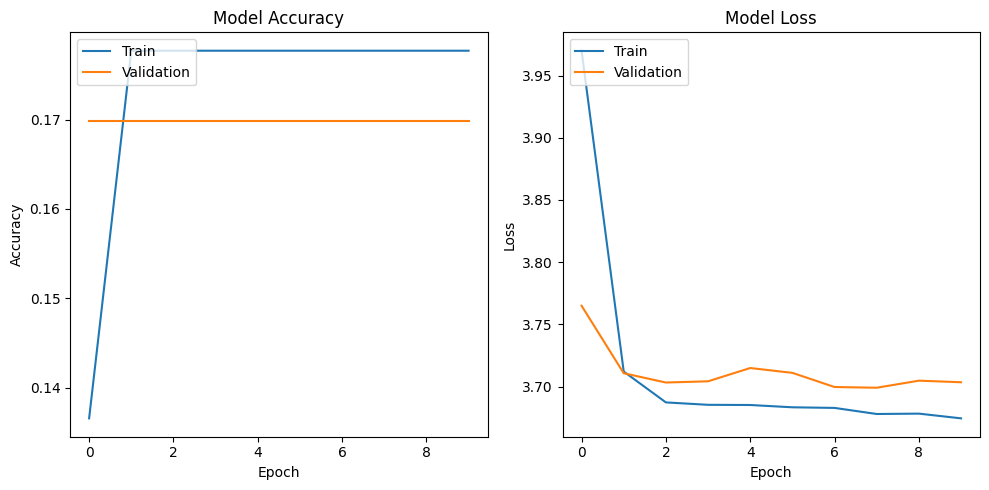

In [18]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])  # Now this line is active
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])  # And this line is active
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.tight_layout()
plt.show()


In [19]:
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder
import numpy as np

# Shuffle and split the dataset.
images, Y = shuffle(images, Y, random_state=1)
train_x, test_x, train_y, test_y = train_test_split(images, Y, test_size=0.3, random_state=415)

# Your pre-built and compiled model, assumed to be trained already.
predictions = model.predict(test_x)
predicted_classes = np.argmax(predictions, axis=1)

# Reverse transform from numerical to original class names
label_encoder = LabelEncoder()
y_labelencoder.fit(people_df['person'].values)  # Fit the label encoder with the original class names
class_names = y_labelencoder.classes_  # This holds the original class names

# Reverse transform the predicted and actual classes to their original names
predicted_class_names = y_labelencoder.inverse_transform(predicted_classes)
actual_class_names = y_labelencoder.inverse_transform(np.argmax(test_y, axis=1))

# Generate the classification report with original class names.
report = classification_report(actual_class_names, predicted_class_names, target_names=class_names)

print(report)


29/29 [==============================] - 5s 156ms/step
                           precision    recall  f1-score   support

         Alejandro_Toledo       0.00      0.00      0.00        13
             Alvaro_Uribe       0.00      0.00      0.00         8
          Amelie_Mauresmo       0.00      0.00      0.00         7
             Andre_Agassi       0.00      0.00      0.00         9
           Angelina_Jolie       0.00      0.00      0.00         7
             Ariel_Sharon       0.00      0.00      0.00        24
    Arnold_Schwarzenegger       0.00      0.00      0.00         9
     Atal_Bihari_Vajpayee       0.00      0.00      0.00         8
             Bill_Clinton       0.00      0.00      0.00         6
             Carlos_Menem       0.00      0.00      0.00         5
             Colin_Powell       0.00      0.00      0.00        92
            David_Beckham       0.00      0.00      0.00         9
          Donald_Rumsfeld       0.00      0.00      0.00        37
      

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
